<h1> Fairness

In [122]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# from aif360.sklearn.metrics import statistical_parity_difference

In [159]:
data = pd.read_csv("dataproject2022.csv", sep=';', index_col="ID",  decimal=',')
print('Shape:', data.shape)
data.head()

Shape: (7440, 14)


,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
ID,,,,,,,,,,,,,,
1,34,55,4875,3087,0,36,0.0479,0,1,1,0,0,0.0245,1
2,5,29,13000,13000,0,60,0.0917,0,0,0,1,0,0.3317,0
3,14,38,17190,14190,0,60,0.0882,0,0,0,0,0,0.1875,0
4,16,37,22773,23568,0,48,0.1101,0,1,1,0,0,0.0354,1
5,1,61,7700,8526,0,48,0.1234,0,1,0,1,0,0.3409,0


In [194]:
X = data.drop(['Pred_default (y_hat)', 'PD','Group'] , axis = 1)
train, test = train_test_split(X, test_size=0.2)

X_train = train.drop('Default (y)', axis=1)
y_train = train['Default (y)']
X_test = test.drop('Default (y)', axis=1)
y_test = test['Default (y)']

rf_tuned = RandomForestClassifier(criterion="gini", max_depth=10, max_features='auto', 
                                  min_samples_leaf=5, min_samples_split=5, n_estimators=100)
rf_tuned.fit(X_train, y_train)
predictions_tuned = rf_tuned.predict(X_test)

print('Random Forest (black-box) Accuracy: %.3f' % accuracy_score(predictions_tuned, y_test))

Random Forest (black-box) Accuracy: 0.809


## Step 10

First, let's plot the default probability given in the data with respect to the age

Text(0, 0.5, 'PD')

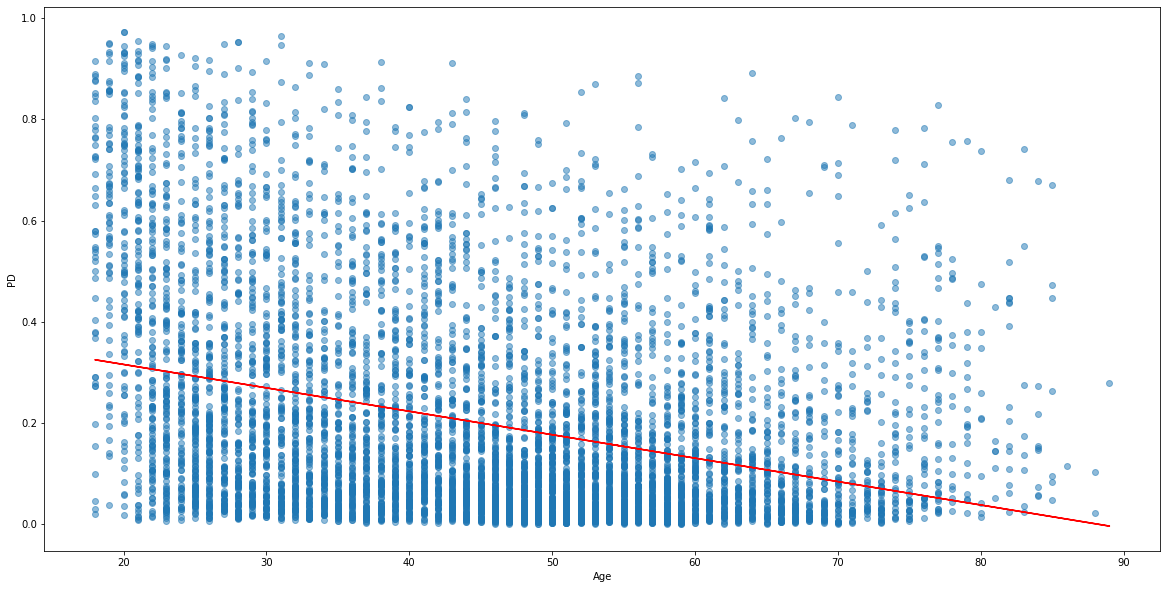

In [38]:
plt.figure(figsize=(20, 10))
plt.scatter(data['Age'], data['PD'], alpha=0.5)
m, b = np.polyfit(data['Age'], data['PD'], 1)
plt.plot(data['Age'], m*data['Age']+b, color='red')
plt.xlabel('Age')
plt.ylabel('PD')

In [32]:
r_value = np.corrcoef(x=data['Age'], y=data['PD'])[0, 1]
r2_value = r_value**2

print('Pearson correlation coefficient:', round(r_value, 3))
print('R-squared:', round(r2_value, 3))

Pearson correlation coefficient: -0.324
R-squared: 0.105


The Pearson correlation coefficient is not very high and the R-squared score is around 10%, which means that the correlation is not very strong.
We'd better create groups of ages.

### 1. Statistical Parity

- H0 : the prediction does not depend on the age category (young and old) - they are independent
- H1 : y_hat and the age category are not independent

#### First, we do it on the given model.

In [129]:
# Print contingency table for the two groups (young and old) for the given model
contingency_table = pd.crosstab(data['Pred_default (y_hat)'], data['Age'] <= np.median(data['Age']), colnames=['Is younger than median age'], rownames=['y_hat'])
contingency_table

Is younger than median age,False,True
y_hat,,
0,3474,3101
1,173,692


In [130]:
# Calculate the chi-squared statistic and p-value
chi2_test = stats.chi2_contingency(contingency_table)
print('Chi-squared statistic:', chi2_test[0])
print('p-value:', chi2_test[1])

Chi-squared statistic: 328.50960356762414
p-value: 2.029550601797998e-73


**Conclusion:**
- We clearly reject H0. 
- There is not statistical parity between people younger than 43 and people older.
- Looking at the contingency table, we can conclude that the model predicts less credit defaults for young people and for old people.

#### Then, we do it on our own model.

In [131]:
# Print contingency table for the two groups (young and old) for the given model
contingency_table = pd.crosstab(predictions_tuned, X_test['Age'] <= np.median(X_test['Age']), colnames=['Is younger than median age'], rownames=['y_hat'])
contingency_table

Is younger than median age,False,True
y_hat,,
0,743,685
1,1,59


In [132]:
# Calculate the chi-squared statistic and p-value
chi2_test = stats.chi2_contingency(contingency_table)
print('Chi-squared statistic:', chi2_test[0])
print('p-value:', chi2_test[1])

Chi-squared statistic: 56.42521008403361
p-value: 5.837708802900506e-14


**Conclusion:**

- We clearly reject H0. 
- There is not statistical parity between people younger than 43 and people older.
- Looking at the contingency table, we can conclude that the model predicts less credit defaults for young people and for old people.


Based on the statistical parity, the chi-squared test shows that the model is not fair. 

### 2. Conditional Statistical Parity

#### First, we do it on the given model.

In [182]:
# Separe the data into two groups (based on the Group column)
data_group_0 = data[data['Group'] == 0]
data_group_1 = data[data['Group'] == 1]
print('Group 0 shape:', data_group_0.shape, '\nGroup 1 shape:', data_group_1.shape)

Group 0 shape: (5139, 14) 
Group 1 shape: (2301, 14)


In [183]:
# Print contingency table for the two groups (young and old) for the given model
ct_group_0 = pd.crosstab(data_group_0['Pred_default (y_hat)'], data_group_0['Age'] <= np.median(data_group_0['Age']), colnames=['Is younger than median age'], rownames=['y_hat'])
print('Group 0 contingency table:')
ct_group_0

Group 0 contingency table:


Is younger than median age,False,True
y_hat,,
0,2294,1999
1,230,616


In [184]:
# Print contingency table for the two groups (young and old) for the given model
ct_group_1 = pd.crosstab(data_group_1['Pred_default (y_hat)'], data_group_1['Age'] <= np.median(data_group_1['Age']), colnames=['Is younger than median age'], rownames=['y_hat'])
print('Group 1 contingency table:')
ct_group_1

Group 1 contingency table:


Is younger than median age,False,True
y_hat,,
0,1105,1177
1,8,11


In [185]:
# Calculate the chi-squared statistic and p-value
chi2_test_group_0 = stats.chi2_contingency(ct_group_0)
print('[Group 0] Chi-squared statistic:', round(chi2_test_group_0[0], 3), '& p-value:', chi2_test_group_0[1])
chi2_test_group_1 = stats.chi2_contingency(ct_group_1)
print('[Group 1] Chi-squared statistic:', round(chi2_test_group_1[0], 3), '& p-value:', chi2_test_group_1[1])

[Group 0] Chi-squared statistic: 193.79 & p-value: 4.731648924488381e-44
[Group 1] Chi-squared statistic: 0.101 & p-value: 0.7503027042833483


**Conclusion:**
- In group 0, we can still reject H0, meaning that there is not statistical parity between people younger than 43 and people older.
- However, in group 1, it's impossible to reject H0 and we can conclude that there is a age statistical parity in this group

#### Then, we do it on our own model.

In [195]:
# Separe the data into two groups (based on the Group column)
test_group_0 = data[data['Group'] == 0].loc[[idx for idx in test.index if idx in data[data['Group'] == 0].index]]
test_group_1 = data[data['Group'] == 1].loc[[idx for idx in test.index if idx in data[data['Group'] == 1].index]]
print('Length of test_group_0:', len(test_group_0), '\nLength of test_group_1:', len(test_group_1))

Length of test_group_0: 1014 
Length of test_group_1: 474


In [196]:
pred_group_0 = pd.Series(predictions_tuned, index=X_test.index).loc[test_group_0.index]
pred_group_1 = pd.Series(predictions_tuned, index=X_test.index).loc[test_group_1.index]
print('Length of pred_group_0:', len(pred_group_0), '\nLength of pred_group_1:', len(pred_group_1))

Length of pred_group_0: 1014 
Length of pred_group_1: 474


In [197]:
# Print contingency table for the two groups (young and old) for the given model
ct_group_0 = pd.crosstab(pred_group_0, test_group_0['Age'] <= np.median(data_group_0['Age']), colnames=['Is younger than median age'], rownames=['y_hat'])
print('Group 0 contingency table:')
ct_group_0

Group 0 contingency table:


Is younger than median age,False,True
y_hat,,
0,466,474
1,5,69


In [198]:
# Print contingency table for the two groups (young and old) for the given model
ct_group_1 = pd.crosstab(pred_group_1, test_group_1['Age'] <= np.median(data_group_1['Age']), colnames=['Is younger than median age'], rownames=['y_hat'])
print('Group 1 contingency table:')
ct_group_1

Group 1 contingency table:


Is younger than median age,False,True
y_hat,,
0,230,244


In [199]:
# Calculate the chi-squared statistic and p-value
chi2_test_group_0 = stats.chi2_contingency(ct_group_0)
print('[Group 0] Chi-squared statistic:', round(chi2_test_group_0[0], 3), '& p-value:', chi2_test_group_0[1])
chi2_test_group_1 = stats.chi2_contingency(ct_group_1)
print('[Group 1] Chi-squared statistic:', round(chi2_test_group_1[0], 3), '& p-value:', chi2_test_group_1[1])

[Group 0] Chi-squared statistic: 48.855 & p-value: 2.7557392514674278e-12
[Group 1] Chi-squared statistic: 0.0 & p-value: 1.0


**Conclusion:**
- In group 0, we can still reject H0, meaning that there is not statistical parity between people younger than 43 and people older.
- However, in group 1, it's impossible to reject H0 and we can conclude that there is a age statistical parity in this group

### 3. Equal Odds